<a href="https://colab.research.google.com/github/Apikmmar/term-deposit-prediction/blob/main/project_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
!{sys.executable} -m pip install scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# install fuzzy package
!pip install -U scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/bank-marketing"

/content/drive/MyDrive/bank-marketing


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import skfuzzy as fuzz
import pandas as pd

from skfuzzy import control as ctrl
from numpy import genfromtxt

In [ ]:
dataset = pd.read_csv('bank-additional.csv', sep=',')
dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [ ]:
# delete unwanted attribute
del dataset['age']
del dataset['job']
del dataset['marital']
del dataset['education']
del dataset['default']
del dataset['contact']
del dataset['month']
del dataset['pdays']
del dataset['duration']
del dataset['day_of_week']
del dataset['campaign']
del dataset['previous']
del dataset['poutcome']
del dataset['nr.employed']
del dataset['emp.var.rate']
del dataset['cons.conf.idx']


print(dataset.columns.tolist())

['housing', 'loan', 'cons.price.idx', 'euribor3m', 'y']


In [ ]:
# convert categorial input from string to int
dataset['housing'] = dataset['housing'].map({
    'yes': 1,
    'unknown': 0.5,
    'no': 0
})

dataset['loan'] = dataset['loan'].map({
    'yes': 1,
    'unknown': 0.5,
    'no': 0
})

dataset['y'] = dataset['y'].map({
    'yes': 1,
    'no': 0
})

In [ ]:
# Antecent
housing = ctrl.Antecedent(np.arange(-1, 1, 0.5), 'housing')
loan = ctrl.Antecedent(np.arange(-1, 1, 0.5), 'loan')
cpi = ctrl.Antecedent(np.arange(dataset['cons.price.idx'].min(), dataset['cons.price.idx'].max(), 1), 'cons.price.idx')
epi = ctrl.Antecedent(np.arange(dataset['euribor3m'].min(), dataset['euribor3m'].max(), 1), 'euribor3m')
subs = ctrl.Consequent(np.arange(dataset['y'].min(), dataset['y'].max(), 0.5), 'y', defuzzify_method='centroid')

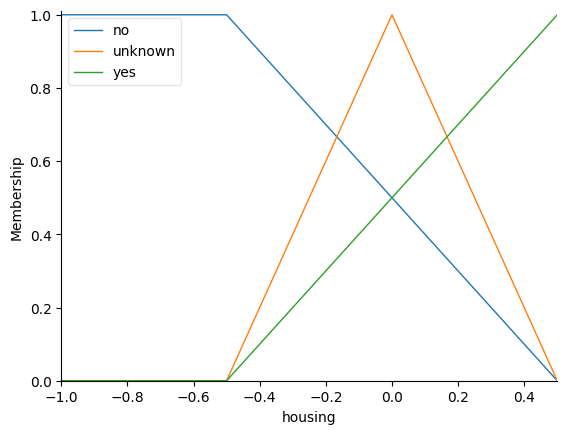

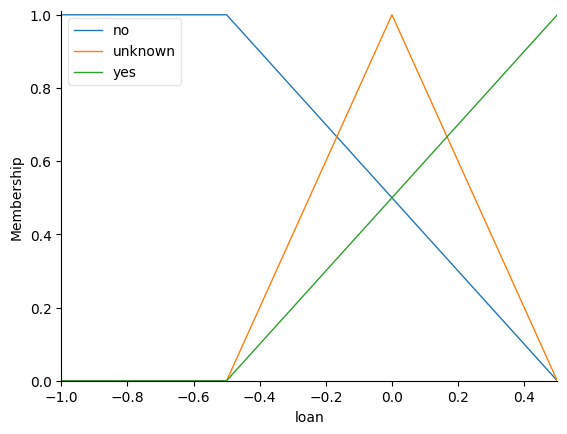

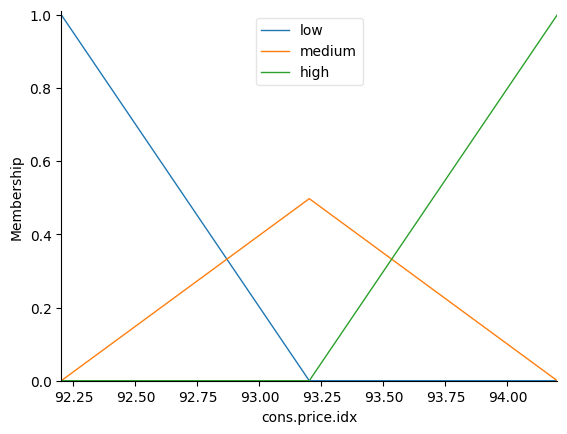

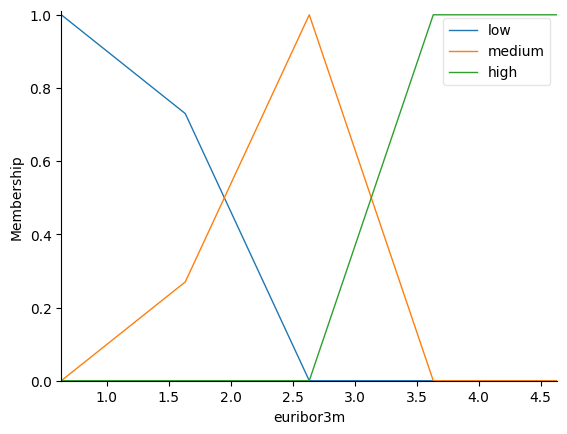

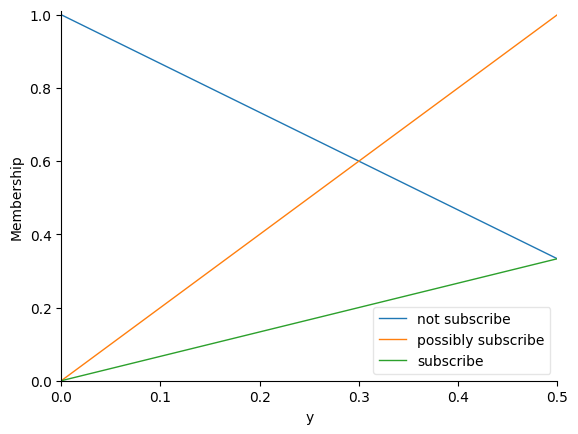

In [ ]:
# housing membership function
housing['no'] = fuzz.trapmf(housing.universe, [-1, -1, -0.3, 0.3])
housing['unknown'] = fuzz.trimf(housing.universe, [-0.5, 0, 0.5])
housing['yes'] = fuzz.trapmf(housing.universe, [-0.3, 0.3, 1, 1])

# loan membership function
loan['no'] = fuzz.trapmf(loan.universe, [-1, -1, -0.3, 0.3])
loan['unknown'] = fuzz.trimf(loan.universe, [-0.5, 0, 0.5])
loan['yes'] = fuzz.trapmf(loan.universe, [-0.3, 0.3, 1, 1])

# cpi membership function
cpi['low'] = fuzz.trapmf(cpi.universe, [92., 92., 92.5, 92.8])
cpi['medium'] = fuzz.trimf(cpi.universe, [92.8, 93.0, 93.4])
cpi['high'] = fuzz.trapmf(cpi.universe, [93.4, 94., dataset['cons.price.idx'].max(), dataset['cons.price.idx'].max()])

# epi membership function
epi['low'] = fuzz.trapmf(epi.universe, [0, 0, 1.5, 2.])
epi['medium'] = fuzz.trapmf(epi.universe, [1.5, 2., 3., 3.5])
epi['high'] = fuzz.trapmf(epi.universe, [3., 3.5, dataset['euribor3m'].max(), dataset['euribor3m'].max()])

# subs membership function
subs['not subscribe'] = fuzz.trapmf(subs.universe, [0, 0, 0.3, 0.6])
subs['possibly subscribe'] = fuzz.trapmf(subs.universe, [0.4, 0.45, 0.55, 0.6])
subs['subscribe'] = fuzz.trapmf(subs.universe, [0.4, 0.7, 1.0, 1.0])

# view membership function
housing.view()
loan.view()
cpi.view()
epi.view()
subs.view()

(<Figure size 640x480 with 1 Axes>, <Axes: >)

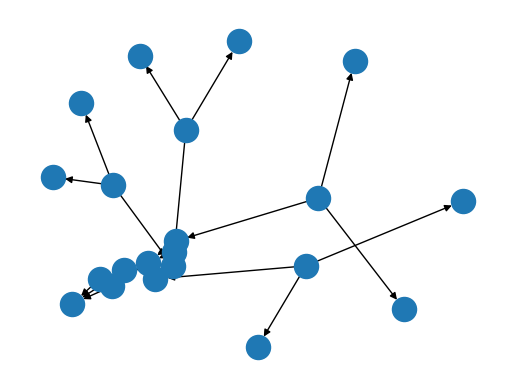

In [ ]:
rule1 = ctrl.Rule(housing['no'] & loan['no'] & cpi['low'] & epi['low'], subs['not subscribe'])

subs_ctrl = ctrl.ControlSystem([
    rule1,
    ctrl.Rule(housing['no'] & loan['no'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['no'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['no'] & cpi['medium'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['no'] & loan['no'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['no'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['no'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['no'] & loan['no'] & cpi['high'] & epi['medium'], subs['subscribe']),
    ctrl.Rule(housing['no'] & loan['no'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['low'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['medium'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['high'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['unknown'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['no'] & loan['yes'] & cpi['low'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['medium'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['high'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['no'] & loan['yes'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['medium'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['high'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['no'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['low'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['medium'] & epi['low'], subs['possibly subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['high'] & epi['low'], subs['possibly subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['high'] & epi['medium'], subs['possibly subscribe']),
    ctrl.Rule(housing['unknown'] & loan['unknown'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['low'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['medium'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['high'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['unknown'] & loan['yes'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['yes'] & loan['no'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['no'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['no'] & cpi['medium'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['yes'] & loan['no'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['no'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['no'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['yes'] & loan['no'] & cpi['high'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['no'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['low'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['medium'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['high'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['unknown'] & cpi['high'] & epi['high'], subs['not subscribe']),

    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['low'] & epi['low'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['low'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['low'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['medium'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['medium'] & epi['medium'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['medium'] & epi['high'], subs['not subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['high'] & epi['low'], subs['subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['high'] & epi['medium'], subs['subscribe']),
    ctrl.Rule(housing['yes'] & loan['yes'] & cpi['high'] & epi['high'], subs['not subscribe']),
])

subs_predict = ctrl.ControlSystemSimulation(subs_ctrl)

rule1.view()

0.3115006904962078


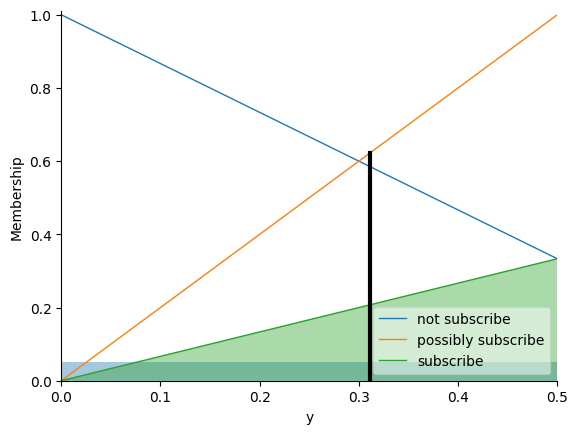

In [ ]:
# test1: subscribe
subs_predict.input['housing'] = 1
subs_predict.input['loan'] = 1
subs_predict.input['cons.price.idx'] = 94.1
subs_predict.input['euribor3m'] = 1.3

subs_predict.compute()

print(subs_predict.output['y'])
subs.view(sim=subs_predict)

0.249889465368499


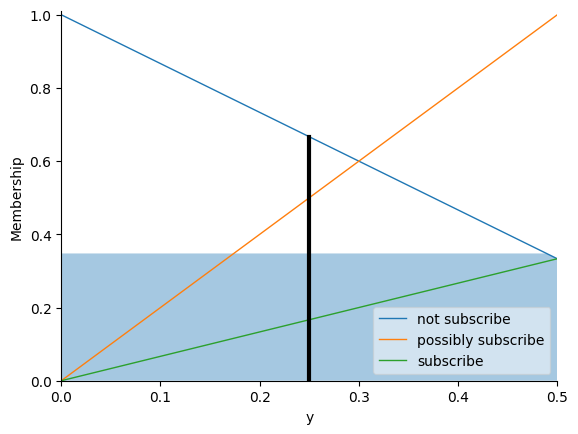

In [ ]:
# test2: not subscribe
subs_predict.input['housing'] = 1
subs_predict.input['loan'] = 1
subs_predict.input['cons.price.idx'] = 92.9
subs_predict.input['euribor3m'] = 3.2

subs_predict.compute()

print(subs_predict.output['y'])
subs.view(sim=subs_predict)

0.25609166666666666


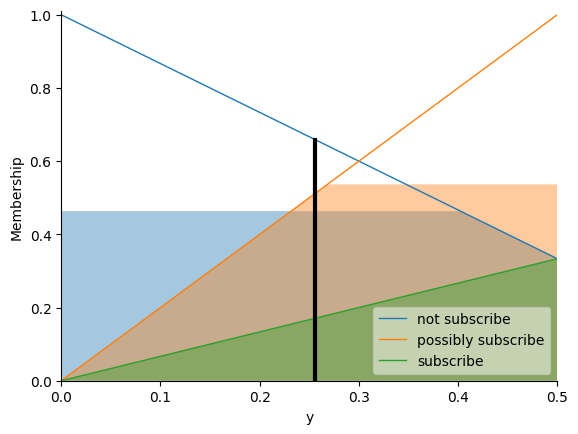

In [ ]:
# test3: possibly subscribe
subs_predict.input['housing'] = 0
subs_predict.input['loan'] = 0
subs_predict.input['cons.price.idx'] = 94.2
subs_predict.input['euribor3m'] = 1.9

subs_predict.compute()

print(subs_predict.output['y'])
subs.view(sim=subs_predict)

0.2545250354618322


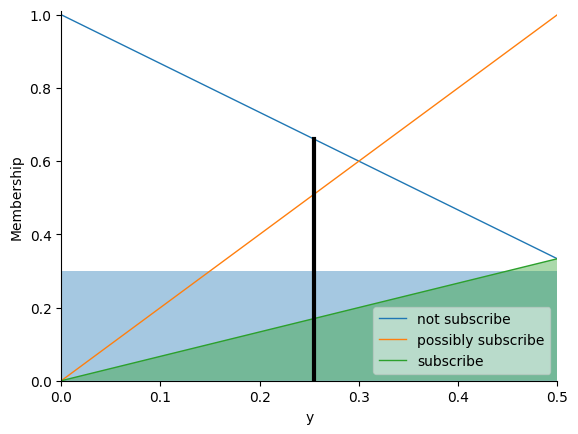

In [ ]:
# test4: not subscribe
subs_predict.input['housing'] = 1
subs_predict.input['loan'] = 1
subs_predict.input['cons.price.idx'] = 93.6
subs_predict.input['euribor3m'] = 2.5

subs_predict.compute()

print(subs_predict.output['y'])
subs.view(sim=subs_predict)

In [ ]:
result = []
predicted = []
compare = []
tr = 0

tp = 0
fn = 0
fp = 0
tn = 0

dataset.reset_index()

count = 0
for index, row in dataset.iterrows():
    print(count, row['housing'], row['loan'], row['cons.price.idx'], row['euribor3m'], row['y'])
    count += 1

    subs_predict.input['housing'] = row['housing']
    subs_predict.input['loan'] = row['loan']
    subs_predict.input['cons.price.idx'] = row['cons.price.idx']
    subs_predict.input['euribor3m'] = row['euribor3m']

    subs_predict.compute()

    p = round(subs_predict.output['y'], 0)

    result.append(subs_predict.output['y'])

    match = p == row['y']

    if (match) : tr += 1

    tp += int((p == 1.) & (row['y'] == 1))
    fn += int((p == 0.) & (row['y'] == 1))
    fp += int((p == 1.) & (row['y'] == 0))
    tn += int((p == 0.) & (row['y'] == 0))

    compare.append(int(match))
    predicted.append(round(subs_predict.output['y'], 0))

print('Total data:', len(dataset))
print('Total true:', tr)
print('Accuracy:', (tr/len(dataset))*100)
print('TP:', tp)
print('FN:', fn)
print('FP:', fp)
print('TN:', tn)

0 1.0 0.0 92.893 1.313 0.0
1 0.0 0.0 93.994 4.855 0.0
2 1.0 0.0 94.465 4.962 0.0
3 0.5 0.5 94.465 4.959 0.0
4 1.0 0.0 93.2 4.191 0.0
5 0.0 0.0 94.199 0.884 0.0
6 1.0 0.0 94.199 0.879 0.0
7 1.0 0.0 93.2 4.191 0.0
8 0.0 0.0 93.2 4.153 0.0
9 0.0 0.0 93.994 4.855 0.0
10 1.0 0.0 93.918 4.958 0.0
11 0.0 0.0 93.918 4.968 0.0
12 0.0 0.0 93.994 4.859 0.0
13 1.0 0.0 94.465 4.958 0.0
14 0.0 0.0 92.893 1.313 0.0
15 0.0 0.0 93.918 4.963 0.0
16 0.0 0.0 93.918 4.957 0.0
17 1.0 0.0 93.918 4.962 0.0
18 1.0 1.0 93.444 4.965 0.0
19 0.0 1.0 93.918 4.961 1.0
20 1.0 0.0 93.918 4.962 0.0
21 0.0 0.0 93.369 0.639 1.0
22 1.0 1.0 93.444 4.967 0.0
23 0.0 1.0 93.444 4.965 0.0
24 1.0 0.0 93.994 4.864 0.0
25 1.0 0.0 93.444 4.965 1.0
26 0.0 0.0 93.994 4.856 0.0
27 0.0 0.0 92.893 1.299 0.0
28 0.0 0.0 93.994 4.86 0.0
29 0.0 0.0 93.444 4.963 0.0
30 1.0 1.0 92.843 1.687 0.0
31 1.0 0.0 94.465 4.865 0.0
32 0.0 0.0 92.963 1.268 0.0
33 1.0 0.0 94.465 4.864 0.0
34 0.0 0.0 93.444 4.962 0.0
35 1.0 0.0 94.465 4.864 0.0
36 1.0 0.

In [ ]:
dataset.insert(5, "result", result, True)
dataset.insert(6, "compare", compare, True)
dataset.insert(7, "predicted", predicted, True)

print(dataset)

# dataset.to_csv('data_summary.csv')

      housing  loan  cons.price.idx  euribor3m  y    result  compare  \
0         1.0   0.0          92.893      1.313  0  0.253292        1   
1         0.0   0.0          93.994      4.855  0  0.216264        1   
2         1.0   0.0          94.465      4.962  0  0.208333        1   
3         0.5   0.5          94.465      4.959  0  0.208333        1   
4         1.0   0.0          93.200      4.191  0  0.241192        1   
...       ...   ...             ...        ... ..       ...      ...   
4114      1.0   1.0          93.918      4.958  0  0.221957        1   
4115      1.0   0.0          93.918      4.959  0  0.221957        1   
4116      0.0   0.0          92.893      1.354  0  0.250000        1   
4117      0.0   0.0          93.444      4.966  0  0.249105        1   
4118      1.0   0.0          93.200      4.120  0  0.241192        1   

      predicted  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
...         ...  
4114     